# Access Search Console Data via Python
> Google's Search Console has come a long way, but there are still times when exploring that data in Python can be particularly useful. This post will show how to download your Google Search Console data via Python.

- toc: false
- branch: master
- badges: true
- categories: [apis,seo,pandas,jupyter]
- hide: false
- search_exclude: false

If this is your first time accessing data from a Google API, there's a lot of setup to be done:
1. Create a project in Google's [Developer Console](https://console.developers.google.com)
2. Enable the API(s) you want to use
3. Create the consent screen
4. Create and download the OAuth credentials
5. Run the script

In this tutorial I'll assume you're running the code from your own computer.

## Lots of Clicking First

There's a lot of steps to get done before actually getting to the code. Since I've found myself having to do this every other year, I figured it'd be good to leave step-by-step notes (screenshots included!).

First, you need to login to [Developer Console](https://console.developers.google.com) and create a project:

![Login to Developer Console and create a project](../images/search_console/01_create_project.png)


If you haven't already, create a new project:

![Create a new project](../images/search_console/02_new_project.png)

Name the project:

![Name the project](../images/search_console/03_name_project.png)

You'll need to find the specific API you want to enable. I've gotten lost trying to find which button will take you to the API library, so [here's the link instead](https://console.developers.google.com/apis/library). When you've found the API you're looking for, click the `Enable` button. While you're at it, you may want to search for and enable others(such as the [Google Analytics Reporting API](https://developers.google.com/analytics/devguides/reporting/core/v4) or the [Youtube Reporting API](https://developers.google.com/youtube/reporting/v1/reports)) since you can add multiple APIs, or scopes, to one credential:

![Enable the Search Console API](../images/search_console/05_enable_api.png)

Since I'll be demonstrating an Oauth verification flow, you'll need to create a consent screen:

![Create a consent screen](../images/search_console/06_consent_screen.png)

There's a dozen fields or so, but only one field in particular matters: the application name. Give it some generic name (but make sure not to include anything related to Google in the name field). You can scoll down to the bottom of the screen and click the Save button.

![Name the screen](../images/search_console/07_name_the_screen.png)

Almost there. Create the credentials; I've selected the OAuth option.

![Create your credentials](../images/search_console/08_create_creds.png)

Again, create a generic name, this time for the credentials themselves. One really, really important note: when I use Jupyter Lab on my Macbook Pro, when it starts up I get a notice that port `8888` is already in use, so instead it moves to port `8889`...you'll need to specifiy an unused port here in the "Authorized redirect URIs" _and_ remember the port because you'll use it again in the code below. In my case, port `8080` works:

![Name the credentials](../images/search_console/09_name_creds.png)

Now download the client secrets, and rename to `client_secrets.json` and move the file to the folder you'll access in the code.

![Download the credentials](../images/search_console/10_download_creds.png)

That marks the end of clicking around in Developer Console. However, note that the first time you run this script you'll have to authorize the script to access your data. Make I'll be using the account for my blog below.

There's a whole suite of Google libraries you'll need to install to make sure the script runs:
* [Google's Python API client](https://github.com/googleapis/google-api-python-client)
* [Google Auth](https://google-auth.readthedocs.io/en/latest/index.html)
* Google's [OAuth integration](https://google-auth-oauthlib.readthedocs.io/en/latest/index.html) with the Google Auth library

Finally, I've found the [Progress](https://pypi.org/project/progress/) library a fun way to keep track of how far the script has progressed.

In [1]:
import os
import json
import time
import glob
import pickle
import random
import pandas as pd
from pandas import Series, DataFrame
from progress.bar import IncrementalBar

# these are just for authenticating
import google.oauth2.credentials
from google_auth_oauthlib.flow import Flow
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# this actually helps access the API
from apiclient.discovery import build

In [2]:
PROPERTY_URI = 'http://measureallthethin.gs/'

OUTPUT_PATH = '../output/search_console_data/'
SECRETS_PATH = '../secrets/'
CLIENT_SECRETS = SECRETS_PATH + 'client_secrets.json'

# notice you can add multiple apis to the credential created earlier :-) 
SCOPES = ['https://www.googleapis.com/auth/webmasters.readonly','https://www.googleapis.com/auth/analytics.readonly']

Probably the most painful part of interfacing with Google's APIs is the fact that every two years the process changes. I spent a whole day and a half trying to figure out how to use the new [Google Auth library](https://google-auth.readthedocs.io/en/latest/index.html) since some of the older libraries have been deprecated. I finally found a great example from the Google Docs team [here](https://github.com/gsuitedevs/python-samples/blob/master/docs/quickstart/quickstart.py) that shows how to easily authenticate from your notebook or command line.

In [3]:
def prepare_credentials():
    creds = None
    # the file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists(SECRETS_PATH + 'token.pickle'):
        with open(SECRETS_PATH + 'token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # if there are no (valid) credentials available, let the user log in
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS, SCOPES)
            creds = flow.run_local_server(port=8080) # remember that port you put into the credentials? use that here in port param
        # save the credentials for the next run
        with open(SECRETS_PATH + 'token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    return creds

As shown above, multiple APIs can be accessed from one project/set of credentials. I access the Google Analytics API frequently, so below is a quick example showing how to be ready for accessing different endpoints.

In [4]:
def initialize_service(service='batch'):
    """
    Returns a connection to the Google Analytics v4 API
    https://developers.google.com/analytics/devguides/reporting/core/v4/rest/
    --OR--
    Returns the Webmaster Service Object
    https://developers.google.com/webmaster-tools/search-console-api-original/v3/searchanalytics/query
    """
    # make sure your authorized to access API first
    credentials = prepare_credentials()
    
    # build and return the service object
    if service == 'batch':
        return build('analyticsreporting',
                     'v4',
                     credentials = credentials,
                     discoveryServiceUrl='https://analyticsreporting.googleapis.com/$discovery/rest?version=v4')
    elif service == 'user_activty':
        return build('analyticsreporting',
                     'v4',
                     credentials = credentials,
                     discoveryServiceUrl='https://analyticsreporting.googleapis.com/v4/userActivity:search')
    elif service == 'webmaster':
        return build('webmasters',
                     'v3',
                     credentials = credentials)
    else:
        raise Exception('Please select an endpoint!')

Typically I do not save the data to a variable but instead save it to disk so I can explore further in a notebook:

In [5]:
# save JSON of each day's/query's results
def file_to_save(start,end,file_info):
    return OUTPUT_PATH + '{0}_{1}_{2}.json'.format(start,end,'_'.join(file_info))

Google loves, _loves_ returning nested JSON, which can be difficult to deal with in Pandas; this function makes it a bit easier to manage.

In [6]:
# "flatten" response a bit so it's easier to convert into a dataframe
def tidy_the_nest(dims,results):
    for item in results:
        for row in item['rows']:
            row.update(dict(zip(dims,row['keys'])))
    return results

Ok, now the for a monster of a function. I've tried commenting inline as much as possible the clarify the pieces, but overall the gist is that the request sent to Google needs to account for 1) the dimensions you want in the data (such as date, search keyword, etc), and 2) a recursive element based on whether or not Google has returned all the rows available to download.

In [7]:
# accepts a list of dimensions by which to query the webmaster api, start and end dates, a collection of data, and integer to increment
def execute_request(dims,start,end,results=None,i=0):
    # saw that get_search_data(["date","query"],date_range) was only returning 5k rows...
    # turns out when adding in keywords that is the max rows search console will return
    # max_rows = 5000
    max_rows = 25000
    if results is None:
        results = []
    # create a dict of what exactly we want to query
    # https://developers.google.com/webmaster-tools/search-console-api-original/v3/searchanalytics/query
    payload = {
        "startDate": start, # [Required] Start date of the requested date range, in YYYY-MM-DD format, in PST time (UTC - 8:00)
        "endDate": end, # [Required] End date of the requested date range, in YYYY-MM-DD format, in PST time (UTC - 8:00)
        "dimensions": dims, # "country", "device", "page", "query", "searchAppearance":
        # https://developers.google.com/webmaster-tools/search-console-api-original/v3/how-tos/all-your-data#overview
        "rowLimit": max_rows, # [Optional; Valid range is 1–25,000; Default is 1,000] The maximum number of rows to return. To page through results, use the startRow offset.
        "startRow": i * max_rows # [Optional; Default is 0] Zero-based index of the first row in the response. Must be a non-negative number. If startRow exceeds the number of results for the query, the response will be a successful response with zero rows.
        }
    # now execute the query and save response
    data = service.searchanalytics().query(siteUrl=PROPERTY_URI, body=payload).execute()
    # max rows is 25000, so need to make sure we didn't leave any data behind
    if 'rows' in data:
        results.append(data)
        num_of_rows = len(data['rows'])
        ### print('Aggregation {0}'.format(data['responseAggregationType']))
        ### print(json.dumps(data['rows'][0:2], sort_keys=True,indent=4, separators=(',', ': ')))
    else:
        num_of_rows = 0
    ### print("Grabbed {0} rows for loop {1}".format(num_of_rows,str(i+1)))
    # get all the data by essentially paginating through results until none are left
    # https://developers.google.com/webmaster-tools/search-console-api-original/v3/how-tos/all-your-data
    # important to note this from the documentation:
    #   Why do I lose data when asking for more detail?
    #   When you group by page and/or query, our system may drop some data in order to be able to calculate results in a reasonable time using a reasonable amount of computing resources.
    #   more about data can be found here https://support.google.com/webmasters/answer/6155685
    if num_of_rows == max_rows:
        time.sleep(1 + random.random())
        i += 1
        return execute_request(dims,start,end,results=results,i=i)
    else:
        tidy_the_nest(dims,results)
        # save the json response because error handling not yet in place
        with open(file_to_save(start,end,dims), 'w') as fp:
            json.dump(results, fp)

Below is essentially a for loop that gets each day of data from a date range and helps keep track of your progress.

In [24]:
def get_search_data(dims,dates,n):
    """
    dims: list of dimensions to include in query
    dates: date range of type pandas.core.indexes.datetimes.DatetimeIndex
    n: string specifying progress of queries to API (e.g., '3 of 5', '4 of 5', '5 of 5')
    """
    # still figuring out how to make Progress bar work in notebooks (this works fine in iTerm...)
    # bar = IncrementalBar('Query {0}: {1}'.format(n,', '.join(dims)), max=len(dates))
    for i in dates:
        date_to_get = '{0}'.format(i.strftime('%Y-%m-%d'))
        time.sleep(1 + random.random())
        # since we are downloading data day by day, start and end dates are the same
        # if you want a range of dates, skip this function and use execute_request() directly
        execute_request(dims,date_to_get,date_to_get)
        # bar.next()
    # bar.finish()

> Important: This will kickoff the process to authorize as well as build the service object with which you can interact with the API. It will print a URL, but should redirect you to that URL automagically. It's more seemless if you are also logged in to the Google profile in your default browser that you want to authorize.

In [9]:
# you should only have to authorize on the first time running this line
service = initialize_service(service = 'webmaster')

As mentioned above, you should automatically get redirected and see a screen like this. Since I am running Jupyter in regular `http` rather than `https` I got the scary red triangle and had to press the "continue anyways" button...

![Download the credentials](../images/search_console/11_authorize.png)

Make sure you have the right list of APIs here:

![Download the credentials](../images/search_console/12_accept.png)

This will let you know you're done:

![Download the credentials](../images/search_console/13_done.png)

Now to finally start getting data! First, set a time range you want to query. I run this script monthly and so use a lazy way of getting one month at a time.

In [10]:
# not strictly necessary to use pandas to convert to timestamp, but helpful to do so in order to get last day of month
start_of_month = '2020-01-01'
end_of_month = pd.to_datetime(start_of_month).to_period('M').to_timestamp('M')
end_of_month

Timestamp('2020-01-31 00:00:00')

In [11]:
# convert start and end dates to date range using Pandas
date_range = pd.date_range(start_of_month,end_of_month,freq='D',normalize=True)

Now that there's a date range to work with, query the API :smiley:

In [12]:
# now start getting the data and saving the JSON files
# more example queries can be found here: https://developers.google.com/webmaster-tools/search-console-api-original/v3/how-tos/search_analytics
# and there are a few more examples below
execute_request(["date"],date_range.min().strftime('%Y-%m-%d'),date_range.max().strftime('%Y-%m-%d'))

You could modify the `execute_request` function above to just `return` the JSON directly, but since I find myself running this script once a month to download the previous month's data, I have my own workflow where I just assume I'm going to combine the output from all the previous months.

In [13]:
def read_json_files(path_to_file):
    with open(path_to_file) as p:
        data = json.load(p)
    return DataFrame.from_dict(data[0]['rows']) 

In [14]:
# i've already download some other months of data besides january, which are shown here
data_files = glob.glob(OUTPUT_PATH + '*_date.json')
data_files[:2]

['../output/search_console_data/2019-11-01_2019-11-30_date.json',
 '../output/search_console_data/2020-01-01_2020-01-31_date.json']

In [15]:
# nice trick from a data science colleague to read in multiple files at once into one dataframe
df = pd.concat([read_json_files(f) for f in data_files], ignore_index=True)
df = df.drop(['keys'],axis=1)
df.head()

,clicks,impressions,ctr,position,date
0,4.0,72.0,0.055556,28.930556,2019-11-01
1,0.0,38.0,0.000000,40.263158,2019-11-02
2,0.0,41.0,0.000000,39.390244,2019-11-03
3,2.0,69.0,0.028986,24.898551,2019-11-04
4,5.0,90.0,0.055556,30.466667,2019-11-05


In [16]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   clicks       123 non-null    float64       
 1   impressions  123 non-null    float64       
 2   ctr          123 non-null    float64       
 3   position     123 non-null    float64       
 4   date         123 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.9 KB


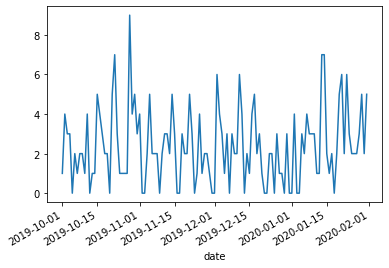

In [17]:
df.set_index('date')['clicks'].plot()

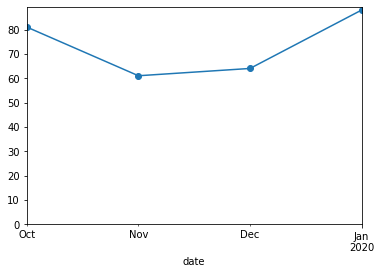

In [18]:
df.groupby([pd.Grouper(key='date',freq='MS')])['clicks'].sum().plot(marker='o',ylim=0);

Here are some more examples of the type of queries I run. Generally, the more granular the less data you get; so I run through a few permutations just to get as much info as I can. With a small blog like this, it doesn't really matter, whereas at work millions of visitors a month can really add up to a lot of rows here...

In [25]:
get_search_data(["date","query","page"],date_range,'1 of 2')
get_search_data(["date","query","page","device","country"],date_range,'2 of 2')